In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import librosa
import scipy
import time

In [10]:
class Wavelet():
    def __init__(self, start, end, signal = None, x = None):
        if not x is None:
            self.x = x
        else:
            self.x = np.linspace(start, end, 1000, endpoint = False)
        if not signal is None:
            self.signal = signal

    def create_signal(self, A = 1, T = None, f = None, type = None):
        if A != 1:
            self.A = A
        if not T is None:
            self.T = T
            self.w = 1 / self.T * 2 * np.pi
        if not f is None and T is None:
            self.w = f * 2 * np.pi
            self.T = 1 / self.w
        if type == 'sin':
            self.signal = A * np.sin(self.x * self.w)
        if type == 'cos':
            self.signal = A * np.cos(self.x * self.w)
    
    def create_noise(self):
        self.noise = self.signal + np.random.normal(0, 1, (self.x).shape)
        return self.noise
    
    def signal_with_time(self, start, end,  A = 1, type = None):
        srate = 1000
        self.x = np.arange(start, end, 1/srate)
        pnts  = len(self.x)
        freqmod = np.exp(-self.x**2) * 10 + 10
        freqmod = freqmod + np.linspace(0, 10, pnts)
        if type == 'sin':
            self.signal  = A * np.sin( 2 * np.pi * (self.x + np.cumsum(freqmod)/srate))
        if type == 'cos':
            self.signal  = A * np.cos( 2 * np.pi * (self.x + np.cumsum(freqmod)/srate))

    def brain_signal(self):
        braindat = sio.loadmat(r'Lab6_Data.mat')
        self.x = braindat['timevec'][0]
        self.srate = braindat['srate'][0]
        self.signal = braindat['data'][0]

    def Morle(self, alpha):
        self.morle = np.exp(-(self.x)**2 / alpha**2)*np.exp(1j * self.x * 2 * np.pi)
        return self.morle
    
    def Mexh(self):
        self.mexh = (1 - self.x**2) * np.exp(- self.x**2 / 2)
        return self.mexh
    
    def Haar(self):
        self.haar = np.zeros(len(self.x))
        for i, x in enumerate(self.x):
            if 0 <= x and x < 0.5:
                self.haar[i] = 1
            if 0.5 <= x and x < 1:
                self.haar[i] = -1
        return self.haar
    
    def spectrogram(self, start, end, signal, time):
        Freq1 = 50
        Freq2  = np.linspace(start, end, Freq1)
        fwhm  = .2 
        pnts = len(time)
        Ws = np.zeros((Freq1, len(time)), dtype=complex)

        for wi in range(0, Freq1):
            gauss = np.exp(-(4 * np.log(2) * time**2) / fwhm**2)
            Ws[wi, :] = np.exp(1j * 2 * np.pi * Freq2[wi] * time) * gauss
            
        conv = pnts * 2-1
        half = int(np.floor(pnts / 2) + 1)
        sigX = scipy.fftpack.fft(signal, conv)
        tf = np.zeros((Freq1, len(time)))

        for fi in range(0, Freq1):
            waveX = scipy.fftpack.fft(Ws[fi,:], conv)
            waveX = waveX / np.max(waveX)
            conv_res = scipy.fftpack.ifft(waveX * sigX)
            conv_res = conv_res[half - 3 : -half]
            tf[fi, :] = np.abs(conv_res)**2
            
        plt.contourf(time, Freq2, tf)
        plt.xlabel('Время')
        plt.ylabel('Частота')
        plt.title('Частотно-временная характеристика')
        plt.show()

    def print_brain_signal(self, srate = None):
        if not srate is None:
            self.srate = srate
        Freq1 = 50 
        Freq2  = np.linspace(8, 70, Freq1)
        fs  = .2 

        Wtime = np.arange(-2, 2, 1 / self.srate)

        Ws = np.zeros((Freq1, len(Wtime)), dtype=complex)

        for wi in range(0,Freq1):
            gauss = np.exp(-(4 * np.log(2) * Wtime**2) / fs**2)
            Ws[wi,:] = np.exp(1j * 2 * np.pi * Freq2[wi] * Wtime) * gauss
            
        conv = len(Wtime) + len(Wtime) - 1
        half = int(np.floor(len(Wtime) / 2))

        dataX = scipy.fftpack.fft(self.signal, conv)

        tf = np.zeros((Freq1, len(Wtime)))

        for fi in range(0,Freq1):
            waveX = scipy.fftpack.fft(Ws[fi,:], conv)
            waveX = waveX/np.max(waveX)

            conv_res = scipy.fftpack.ifft( waveX*dataX )
            conv_res = conv_res[half-1 : -half]
            
            tf[fi,:] = np.abs(conv_res)**2
        plt.pcolormesh(Wtime, Freq2, tf, vmin=0, vmax=1e3, cmap = 'gist_heat')
        plt.xlabel('Время')
        plt.ylabel('Частота')
        plt.title('Частотно-временная характеристика')
        plt.show()

    def signal_spectrum(self, signal = None, print = False):
        if signal is None:
            xff = np.arange(len(self.x))
            yff = np.fft.fft(self.signal) / len(self.x)
        else:
            xff = np.arange(len(self.x))
            yff = np.fft.fft(signal) / len(self.x)

        if print:
            plt.xlim(0, 100)
            plt.xlabel('Частота, Гц')
            plt.ylabel('Амплитуда, м')
            plt.title('fft')
            plt.plot(xff, 2 * np.abs(yff))
            plt.show()
        return xff, yff 
    
    def my_convolution(self, signal, type = None):
        if type == 'morle':
            return np.fft.ifft(np.fft.fft(signal) * np.fft.fft(self.morle))
        if type == 'mexh':
            return np.fft.ifft(np.fft.fft(signal) * np.fft.fft(self.mexh))
        if type == 'haar':
            return np.fft.ifft(np.fft.fft(signal) * np.fft.fft(self.haar))
    
    def convolution(self, type = None):
        if type == 'morle':
            return np.convolve(self.signal, self.morle, mode='same') / sum(self.morle)
        if type == 'mexh':
            return np.convolve(self.signal, self.mexh, mode='same') / sum(self.mexh) 
        if type == 'haar':
            return np.convolve(self.signal, self.haar, mode='same') / sum(self.haar) 
    
    def print_signal(self, y = None, y2 = None, title='Сигнал'):
        if not y is None:
            plt.xlabel('Время, t')
            plt.ylabel('Амплитуда, м')
            if not y2 is None:
                plt.plot(self.x, y2, 'pink')            
            plt.plot(self.x, y)
            plt.title(title)
            plt.grid()
            plt.show() 
        else:
            plt.xlabel('Время, t')
            plt.ylabel('Амплитуда, м')
            if not y2 is None:
                plt.plot(self.x, y2, 'pink')
            plt.plot(self.x, self.signal)
            plt.title(title)
            plt.grid()
            plt.show()   

# Задание №1

### Вейвлет Морле

c:\Users\Sofia\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


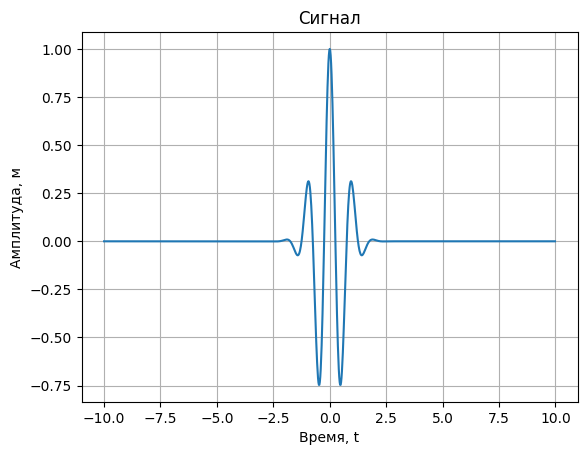

In [11]:
signal = Wavelet(-10.0, 10.0)
morle = signal.Morle(0.9)
signal.print_signal(morle)


### Спектр Морле

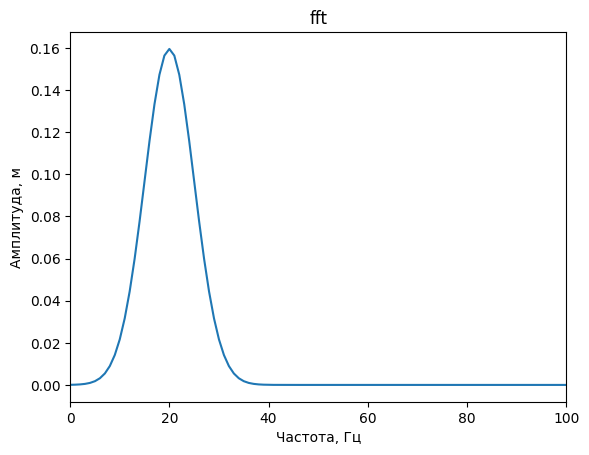

In [12]:
xf, yf = signal.signal_spectrum(morle, print=True)

# Задание №2

### Вейвлет "Мексиканская шляпа"

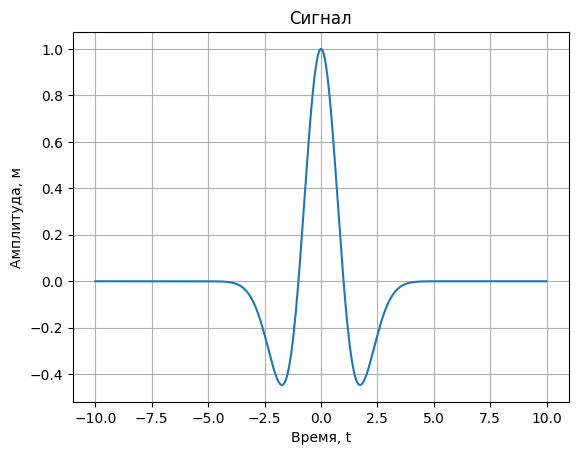

In [13]:
mexh = signal.Mexh()
signal.print_signal(mexh)

### Спектр вейвлета "Мексиканская шляпа"

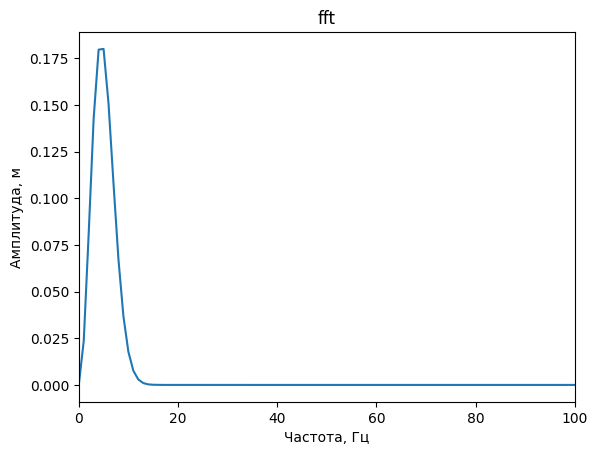

In [14]:
xf, yf = signal.signal_spectrum(mexh, print=True)

# Задание №3

### Вейвлет Хаара

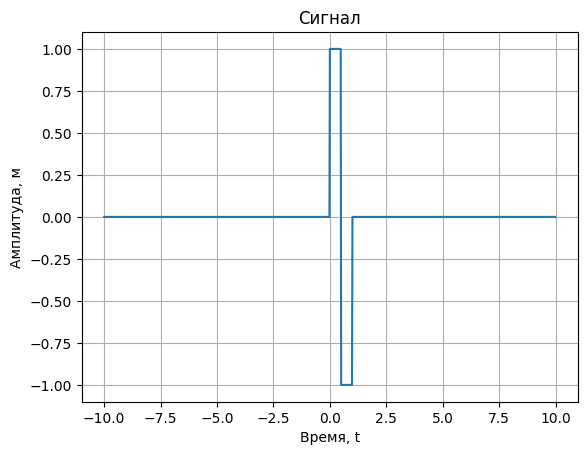

In [15]:
haar = signal.Haar()
signal.print_signal(haar)

### Спектр Хаара

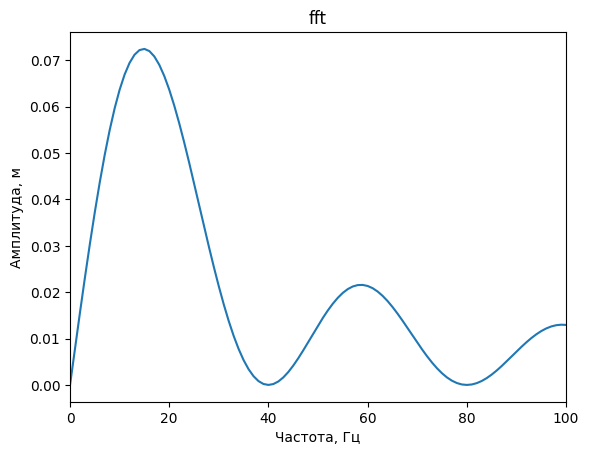

In [16]:
xf, yf = signal.signal_spectrum(haar, print=True)

# Задание №4

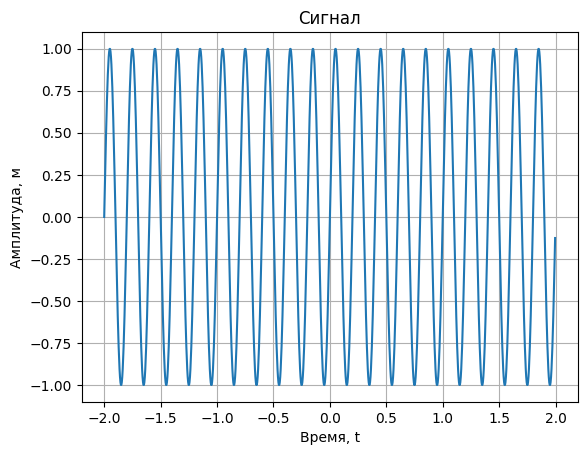

In [17]:
signal = Wavelet(-2, 2)
signal.create_signal(f = 5, type =  'sin')
signal.print_signal()

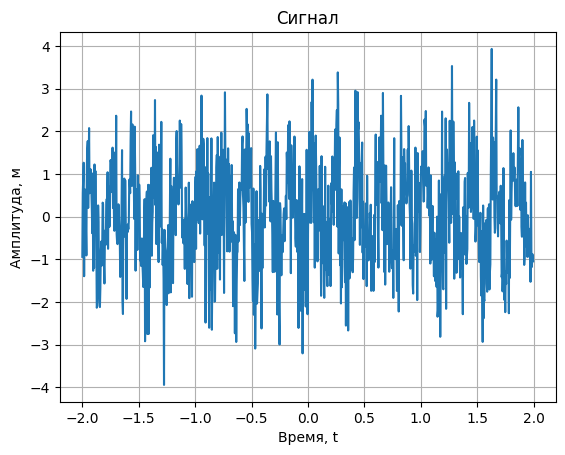

In [18]:
noise = signal.create_noise()
signal.print_signal(noise)

### Реализовать свертку сигнала с вейвлетам Морле

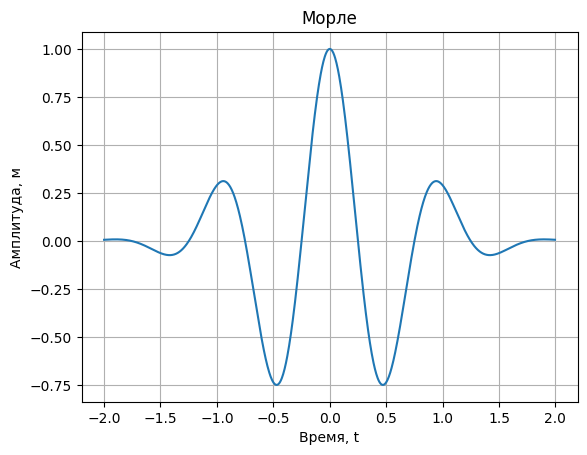

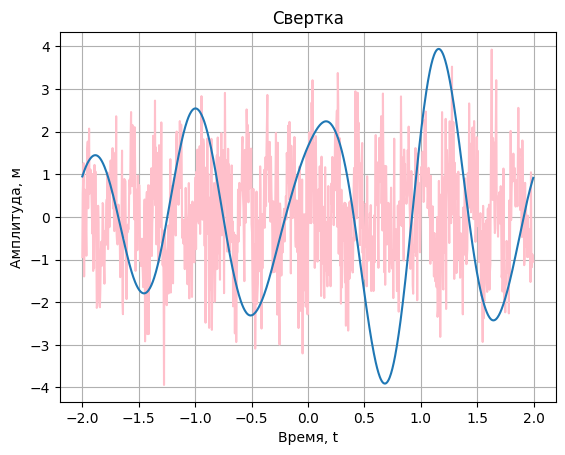

In [19]:
morle = signal.Morle(0.9)
signal.print_signal(morle, title = 'Морле')

conv_morle = np.fft.ifft(np.fft.fft(morle)*np.fft.fft(noise))
conv_morle *= max(noise)/max(conv_morle)
signal.print_signal(conv_morle, y2 = noise, title = 'Свертка')

### Реализовать свертку сигнала с Мексиканской шляпой

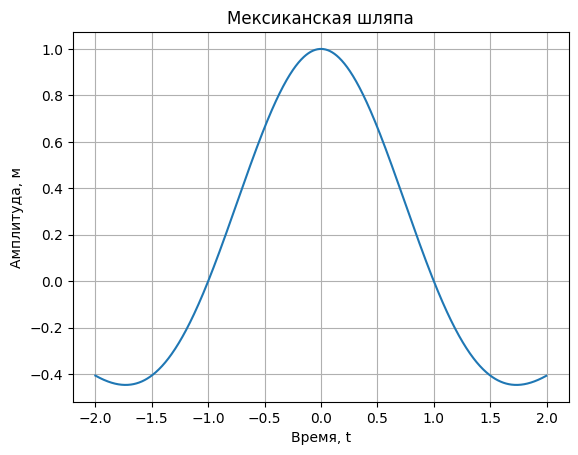

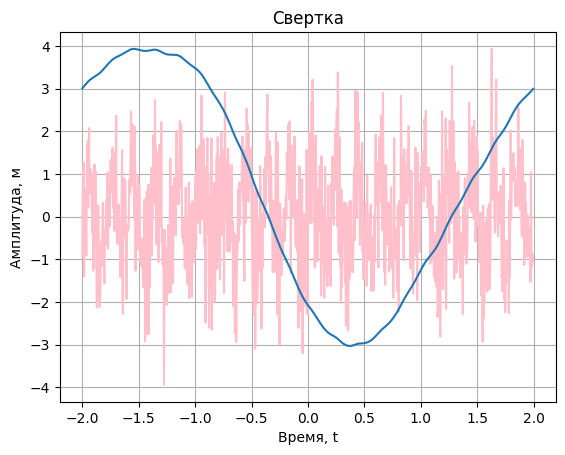

In [20]:
mexh = signal.Mexh()
signal.print_signal(mexh, title = 'Мексиканская шляпа')

conv_mexh = np.fft.ifft(np.fft.fft(mexh)*np.fft.fft(noise))
conv_mexh *= max(noise)/max(conv_mexh)
signal.print_signal(conv_mexh,y2 = noise, title = 'Свертка')

### Реализовать свертку сигнала с вейвлетом Хаара

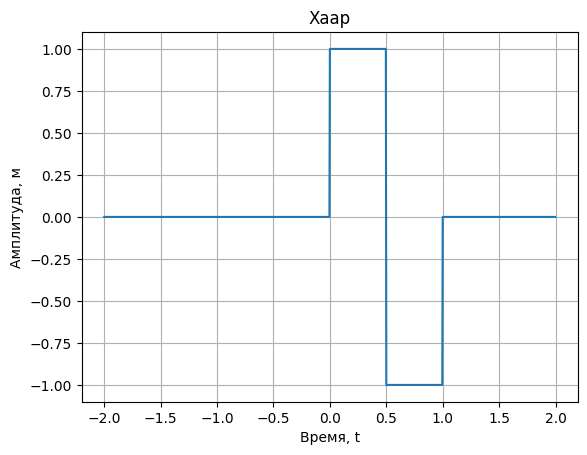

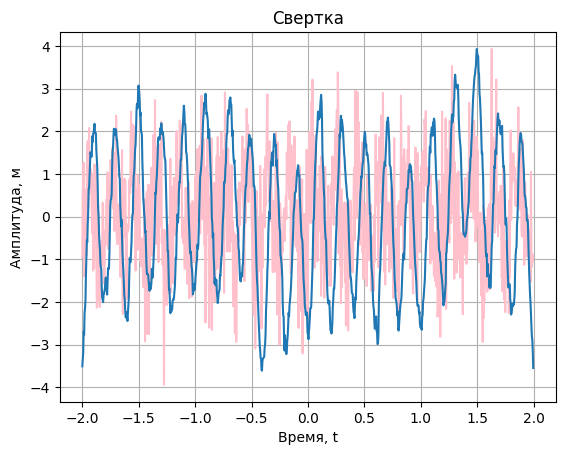

In [21]:
haar = signal.Haar()
signal.print_signal(haar, title='Хаар')

conv_haar = np.fft.ifft(np.fft.fft(haar)*np.fft.fft(noise))
conv_haar *= max(noise)/max(conv_haar)
signal.print_signal(conv_haar, y2 = noise, title = 'Свертка')

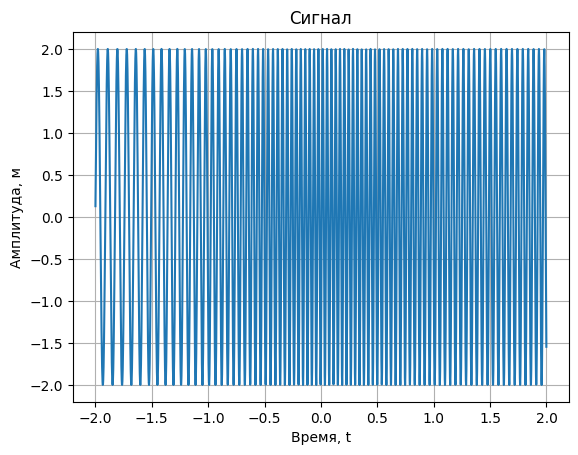

In [22]:
signal.signal_with_time(-2, 2, A = 2,  type = 'sin')
signal.print_signal()

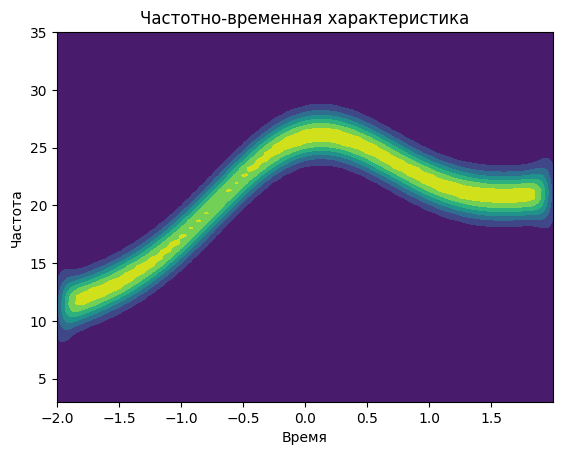

In [23]:
signal.spectrogram(3, 35, signal.signal, signal.x)

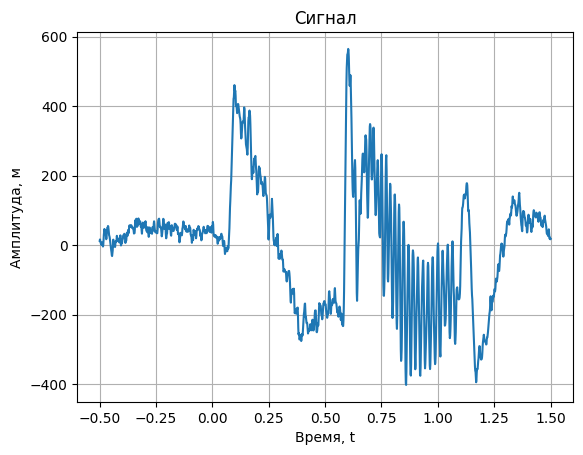

In [24]:
signal.brain_signal()
signal.print_signal()

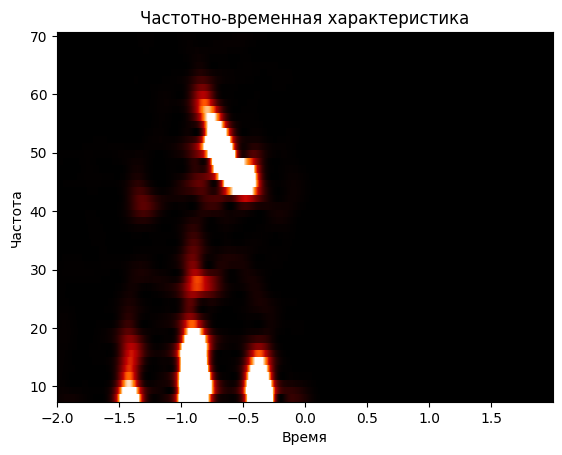

In [25]:
signal.print_brain_signal()

In [26]:
y, sr = librosa.load(r'aphex_twin_equation.wav', offset=1.0, duration=1.0)

In [27]:
time_vec = np.linspace(0, 1000, len(y))

In [28]:
signal = Wavelet(-2, 2, y, time_vec)

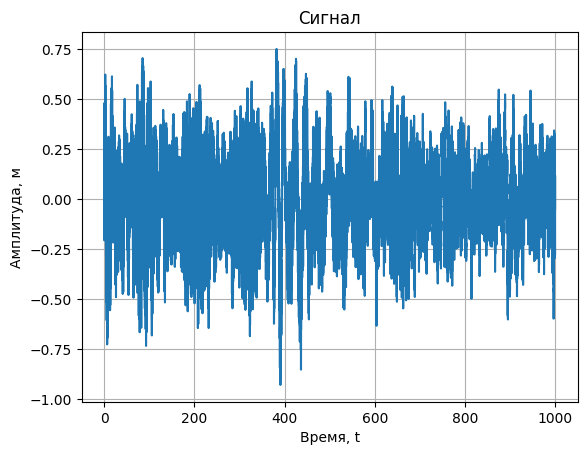

In [29]:
signal.print_signal()

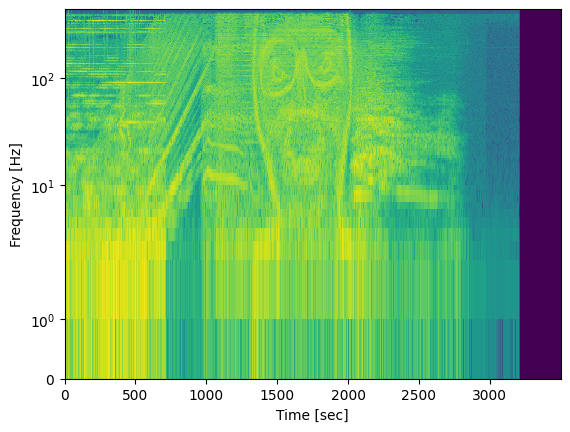

In [30]:
import numpy as np
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt

SAMPLE_RATE = 44100
song = read("aphex_twin_equation.wav")[1][:,0]  # read song left stereo
song = song/np.max(np.abs(song)) #normalize song
# Defining two parameters
window_size = int(0.02 * SAMPLE_RATE)
step_size = int(0.01 * SAMPLE_RATE)

# Extract strided windows
leftover = (len(song) - window_size) % step_size
song = song[:len(song) - leftover] # remove leftover 56 data points from end
nshape = (window_size, (len(song) - window_size) // step_size + 1) # (882, 3499)
nstrides = (song.strides[0], song.strides[0] * step_size) # (8, 3528)
windows = np.lib.stride_tricks.as_strided(song, shape = nshape, strides = nstrides) #windows extracted
# Window weighting
weighting = np.hanning(window_size)[:, None]

# squared Fast Fourier Transform (fft)
fft = np.fft.fft(windows * weighting, axis=0)
fft = fft[:442] # Since it's mirrored take first half
fft = np.absolute(fft) # absolute FFTs of the windowed data
fft = fft**2

spectrogram = 10 * np.log(fft + 1e-14) # 10 ∗ log10(x + c) to smooth the data for a better representation

plt.pcolormesh(spectrogram) # for obtaining a visual from the data
plt.ylabel('Frequency [Hz]')
plt.yscale('symlog') # The artist hid the face into log scale. Thus, ’y scale’ selected as ’symlog’.
plt.xlabel('Time [sec]')
plt.show()